In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import warnings
from joblib import Parallel, delayed


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 312)

/Users/gustavnielsen/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Random Forest

## Import data

In [3]:
data = pd.read_csv('HR_data.csv').drop([104, 120, 122, 125, 272])
X_data = data[['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min',
       'HR_TD_Max', 'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope',
       'TEMP_TD_Mean', 'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min',
       'TEMP_TD_Max', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew',
       'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean',
       'TEMP_TD_Slope', 'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std',
       'EDA_TD_P_Min', 'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis',
       'EDA_TD_P_Skew', 'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max',
       'EDA_TD_P_Slope_mean', 'EDA_TD_P_Slope', 'EDA_TD_T_Mean',
       'EDA_TD_T_Median', 'EDA_TD_T_std', 'EDA_TD_T_Min', 'EDA_TD_T_Max',
       'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew',
       'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max', 'EDA_TD_T_Slope_mean',
       'EDA_TD_T_Slope', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT', 'EDA_TD_P_ReT',
       'Round', 'Phase', 'Individual', 'Puzzler', 'Cohort']]

y_string = ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous', 'determined', 'attentive', 'afraid', 'active' ]
y_data = data[y_string]

In [281]:
def encoding(X, y, type = 'dummy'):
    X = X.copy()
    y = y.copy()
    if type == 'dummy':
        X = pd.get_dummies(X, columns=['Round', 'Phase', 'Individual', 'Cohort']).astype('int')
    elif type == 'ordinal':
        pass
        round_mapping = {'round_1': 1, 'round_2': 2, 'round_3': 3, 'round_4': 4}
        cohort_mapping = {'D1_1': 1, 'D1_2': 2, 'D1_3': 3, 'D1_4': 4, 'D1_5': 5, 'D1_6': 6}
        phase_mapping = {'phase1': 1, 'phase2': 2, 'phase3': 3}

        X['Round'] = X['Round'].map(round_mapping)
        X['Cohort'] = X['Cohort'].map(cohort_mapping)
        X['Phase'] = X['Phase'].map(phase_mapping)

    return X, y

In [306]:
def grid_search_adaboost_parallel(X, y, y_string, param_grid, encoding_type='dummy'):
    X = X.copy()
    y = y.copy()

    X, y = encoding(X, y, encoding_type)

    def search(y_target):
        X_train, X_test, y_train, y_test = train_test_split(X, y[y_target].values, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Opret en beslutningstræmodel
        tree = DecisionTreeClassifier()
        adaboost = AdaBoostClassifier(base_estimator=tree)

        grid_search = GridSearchCV(adaboost, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        return {
            y_target: {
                'depth': grid_search.best_params_['base_estimator__max_depth'],
                'n_estimators': grid_search.best_params_['n_estimators'],
                'learning_rate': grid_search.best_params_['learning_rate'],
                'best_score': grid_search.best_score_
            }
        }
    

    results = Parallel(n_jobs=-1)(delayed(search)(y_target) for y_target in y_string)

    best_params_df = pd.DataFrame.from_dict({k: v for d in results for k, v in d.items()}, orient='index')
    return best_params_df.T


def grid_search_random_forest_parallel(X, y, y_string, param_grid, encoding_type='dummy'):
    X = X.copy()
    y = y.copy()

    X, y = encoding(X, y, encoding_type)
    
    
    def search(y_target):
        X_train, X_test, y_train, y_test = train_test_split(X, y[y_target].values, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Opret en Random Forest-model
        random_forest = RandomForestClassifier()

        grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        return {
            y_target: {
                'depth': grid_search.best_params_['max_depth'],
                'n_estimators': grid_search.best_params_['n_estimators'],
                'best_score': grid_search.best_score_
            }
        }

    results = Parallel(n_jobs=-1)(delayed(search)(y_target) for y_target in y_string)

    best_params_df = pd.DataFrame.from_dict({k: v for d in results for k, v in d.items()}, orient='index')
    return best_params_df.T

def get_param(param, target, regression_type = 'adaboost'):
    if regression_type == 'adaboost':
        return  int(param.loc['depth', target]), int(param.loc['n_estimators', target]),  param.loc['learning_rate', target]
    elif regression_type == 'random_forest':
        return  int(param.loc['depth', target]), int(param.loc['n_estimators', target])

In [307]:
param_grid_adaboost = {
    'base_estimator__max_depth': [3],
    'n_estimators': [100],
    'learning_rate': [0.1]
}
param_grid_random_forest = {
    'max_depth': [3],
    'n_estimators': [100]
}
adaboost_ordinal = grid_search_adaboost_parallel(X_data.copy(), y_data.copy(), y_string, param_grid_adaboost, 'ordinal')
adaboost_dummy = grid_search_adaboost_parallel(X_data.copy(), y_data.copy(), y_string, param_grid_adaboost, 'dummy')

random_forest_dummy = grid_search_random_forest_parallel(X_data.copy(), y_data.copy(), y_string, param_grid_random_forest, 'dummy')
random_forest_ordinal = grid_search_random_forest_parallel(X_data.copy(), y_data.copy(), y_string, param_grid_random_forest, 'ordinal')

In [305]:
random_forest_dummy.head()

,Frustrated,upset,hostile,alert,ashamed,inspired,nervous,determined,attentive,afraid,active
max_depth,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
n_estimators,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
best_score,0.367347,0.726531,0.963265,0.440816,0.832653,0.412245,0.677551,0.232653,0.404082,0.971429,0.395918


In [310]:
def calculate_feature_importances(X, y, param, y_target='Frustrated', regression_type = 'adaboost'):
    '''Denne kode bruges til at udregne hvor vigtig en feature er baseret på adaboost.'''

    X_train, X_test, y_train, y_test = train_test_split(X, y[y_target].values, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    if regression_type == 'adaboost':
        depth, n_estimators, learning_rate = get_param(param, y_target, regression_type)
        tree = DecisionTreeClassifier(max_depth=depth)
        model = AdaBoostClassifier(estimator=tree, n_estimators=n_estimators, learning_rate=learning_rate)
    elif regression_type == 'random_forest':
        depth, n_estimators = get_param(param, y_target, regression_type)
        model = RandomForestClassifier(max_depth=depth, n_estimators=n_estimators) 
        
    model.fit(X_train, y_train)

    total_feature_importances = np.zeros(X_train.shape[1])

    for reg in model.estimators_:
        feature_importances = reg.feature_importances_
        total_feature_importances += feature_importances

    average_feature_importances = total_feature_importances / len(model.estimators_)
    feature_importance_matrix = np.column_stack((X.columns, average_feature_importances))

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return feature_importance_matrix, accuracy

In [296]:
def plot_feature_importances(X, y, param, target, encoding_type = 'dummy', regression_type = 'adaboost'):

    X, y = encoding(X, y, encoding_type)

    feature_importance_matrix, _ = calculate_feature_importances(X, y, param, target, regression_type)
    features = feature_importance_matrix[:, 0]
    importance_values = feature_importance_matrix[:, 1].astype(float)
 
    plt.figure(figsize=(25, 5))
    plt.bar(features, importance_values, color='skyblue')
    plt.ylabel('Feature Importance')
    plt.xlabel('Feature')
    plt.title(f'Feature Importance Plot for \"{target}\" using {regression_type} with encoding: {encoding_type}')
    plt.xticks(rotation=90)  
    plt.show()


def plot_feature_importances_all_targets(X, y, param, y_string, encoding_type = 'dummy', regression_type = 'adaboost'):

    plt.figure(figsize=(25, 5))

    X, y = encoding(X, y, encoding_type)

    for i, target in enumerate(y_string):

        feature_importance_matrix, _ = calculate_feature_importances(X, y, param, target, regression_type)
        
        features = feature_importance_matrix[:, 0]
        importance_values = feature_importance_matrix[:, 1].astype(float)

        offset = 0.1 * i
        plt.bar(np.arange(len(features)) + offset, importance_values, width=0.1, label=target)

    plt.ylabel('Feature Importance')
    plt.xlabel('Feature')
    plt.title('Feature Importance Plot for All Targets')
    plt.xticks(np.arange(len(features)) + 0.1, features, rotation=90)  # Drej x-akse mærkerne for at undgå overlappende labels
    plt.legend()
    plt.show()

def plot_average_feature_importances_all_targets(X, y, param, y_string, encoding_type = 'dummy', regression_type = 'adaboost', show_plot = 'False'):

    X, y = encoding(X, y, encoding_type)
    total_feature_importances = np.zeros(X.shape[1])

    for target in y_string:

        feature_importance_matrix, _ = calculate_feature_importances(X, y, param, target, regression_type)

        total_feature_importances += feature_importance_matrix[:, -1].astype(float)
#
    average_importances = total_feature_importances / np.sum(total_feature_importances)

    features = feature_importance_matrix[:, 0]

    sorted_indices = np.argsort(average_importances)[::-1]
    sorted_features = features[sorted_indices]
    sorted_importances = average_importances[sorted_indices]
    if show_plot:
        plt.figure(figsize=(25, 5))
        plt.bar(np.arange(len(features)), sorted_importances, color='skyblue')
        plt.ylabel('Average Feature Importance')
        plt.xlabel('Feature')
        plt.title(f'Average Feature Importance Plot for All Targets. Regression used: {regression_type} with {encoding_type} encoding')
        plt.xticks(np.arange(len(features)), sorted_features, rotation=90) 
        plt.show()

    return np.column_stack([features, average_importances])

def plot_average_feature_different_regression(feature_list):

    plt.figure(figsize=(25, 5))
    
    for i, data in enumerate(feature_list):
        offset = 0.1 * i
        plt.bar(np.arange(len(data[:,0])) + offset, data[:,1], width=0.1)

    plt.ylabel('Feature Importance')
    plt.xlabel('Feature')
    plt.title('Feature Importance Plot for All Targets')
    plt.xticks(np.arange(len(data[:,0])) + 0.1, data[:,0], rotation=90)  # Drej x-akse mærkerne for at undgå overlappende labels
    plt.legend()
    plt.show()



In [283]:
#plot_feature_importances(X_data.copy(), y_data.copy(), adaboost_dummy, 'upset', 'dummy', 'adaboost')

In [284]:
#plot_feature_importances_all_targets(X_data.copy(), y_data.copy(), adaboost_dummy, y_string[:5], 'dummy', 'adaboost')

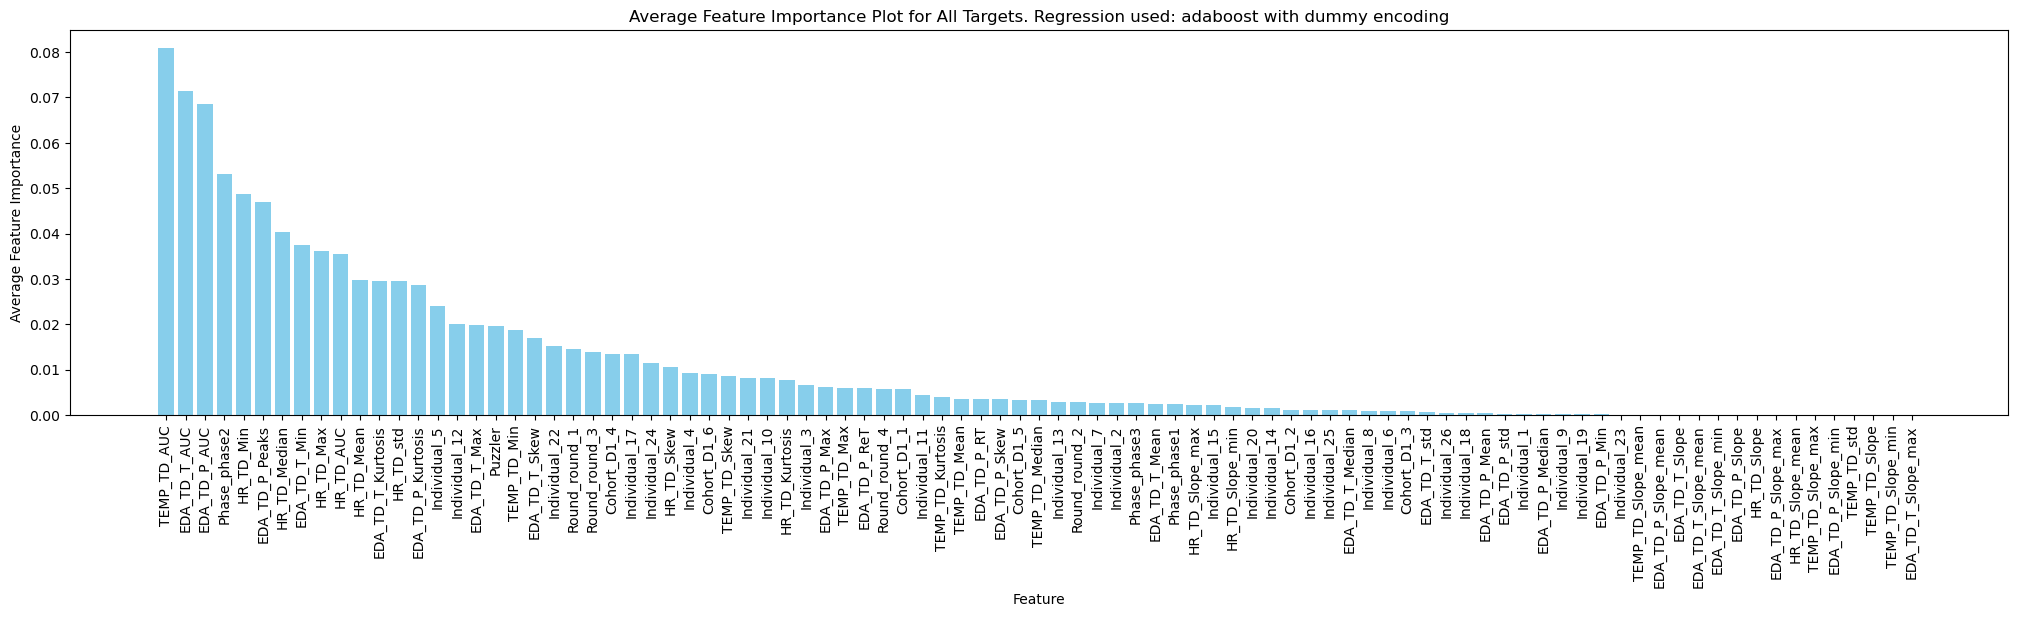

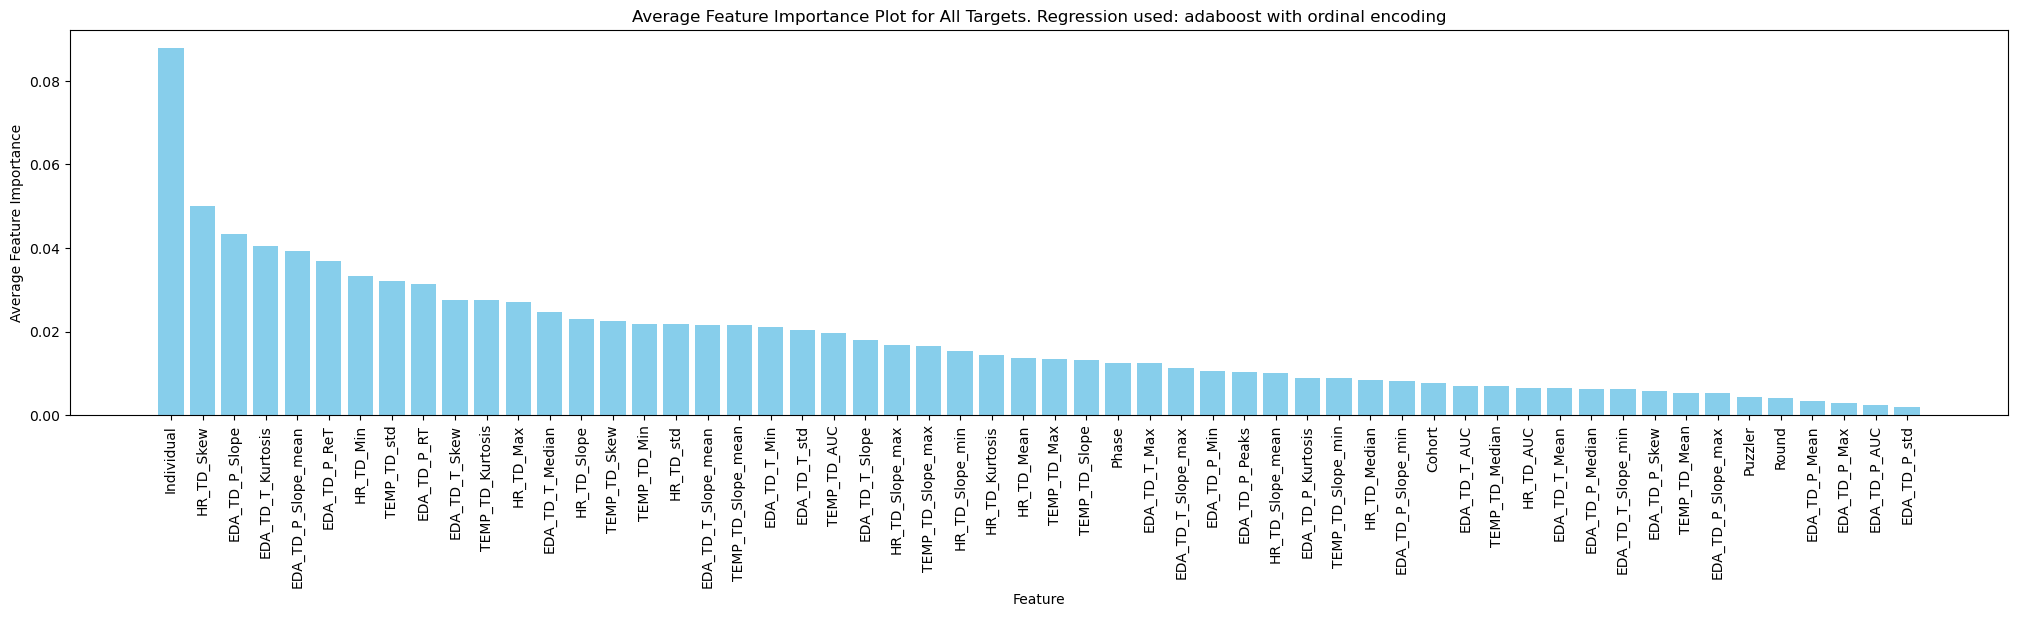

In [308]:
adaboost_dummy_res = plot_average_feature_importances_all_targets(X_data.copy(), y_data.copy(), adaboost_dummy, y_string, 'dummy', 'adaboost', show_plot = True)
adaboost_ordinal_res = plot_average_feature_importances_all_targets(X_data.copy(), y_data.copy(), adaboost_ordinal, y_string, 'ordinal', 'adaboost', show_plot = True)

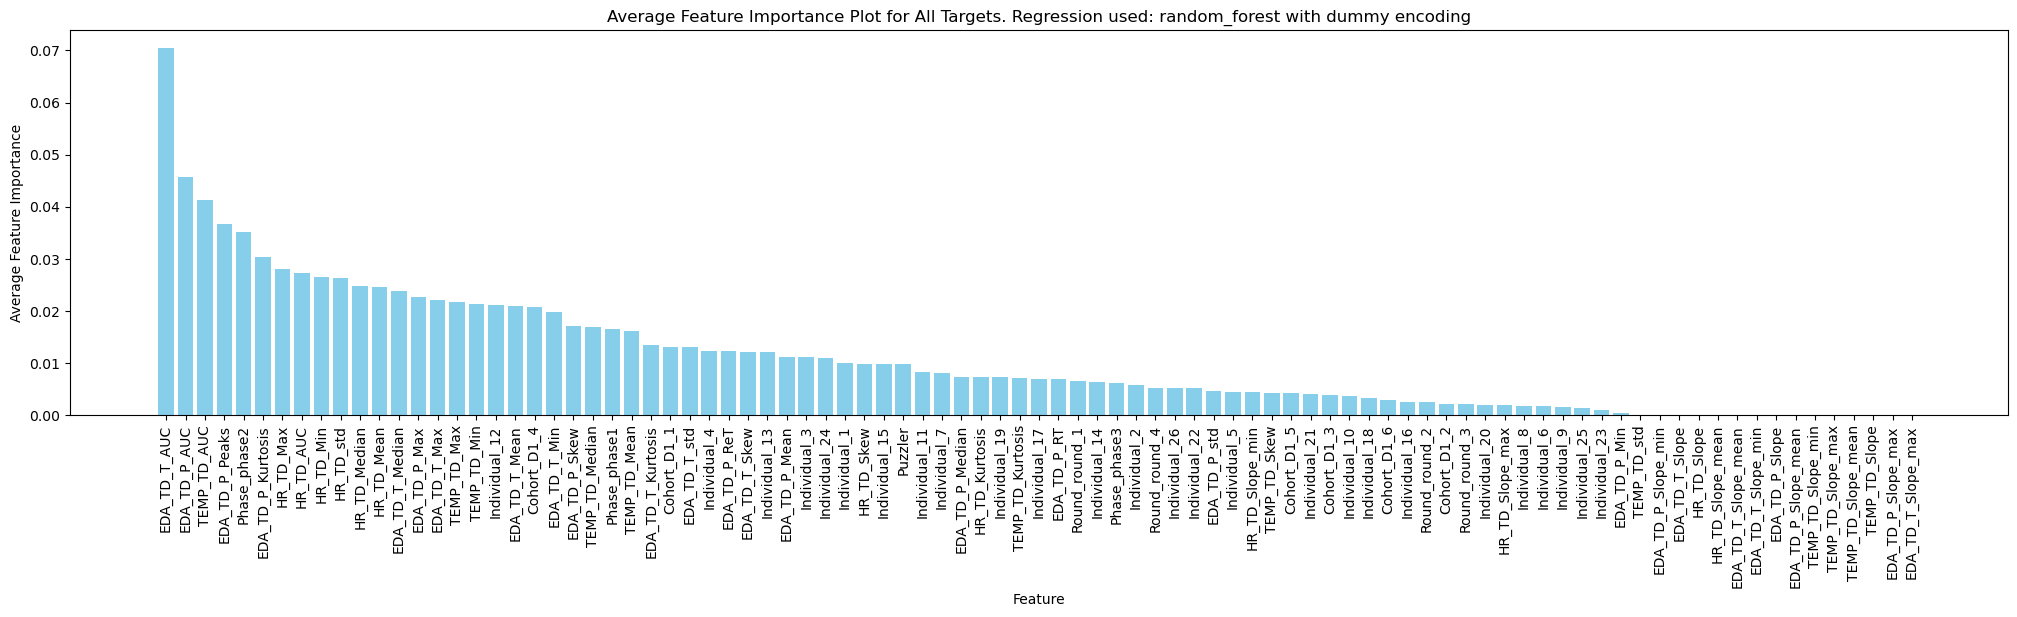

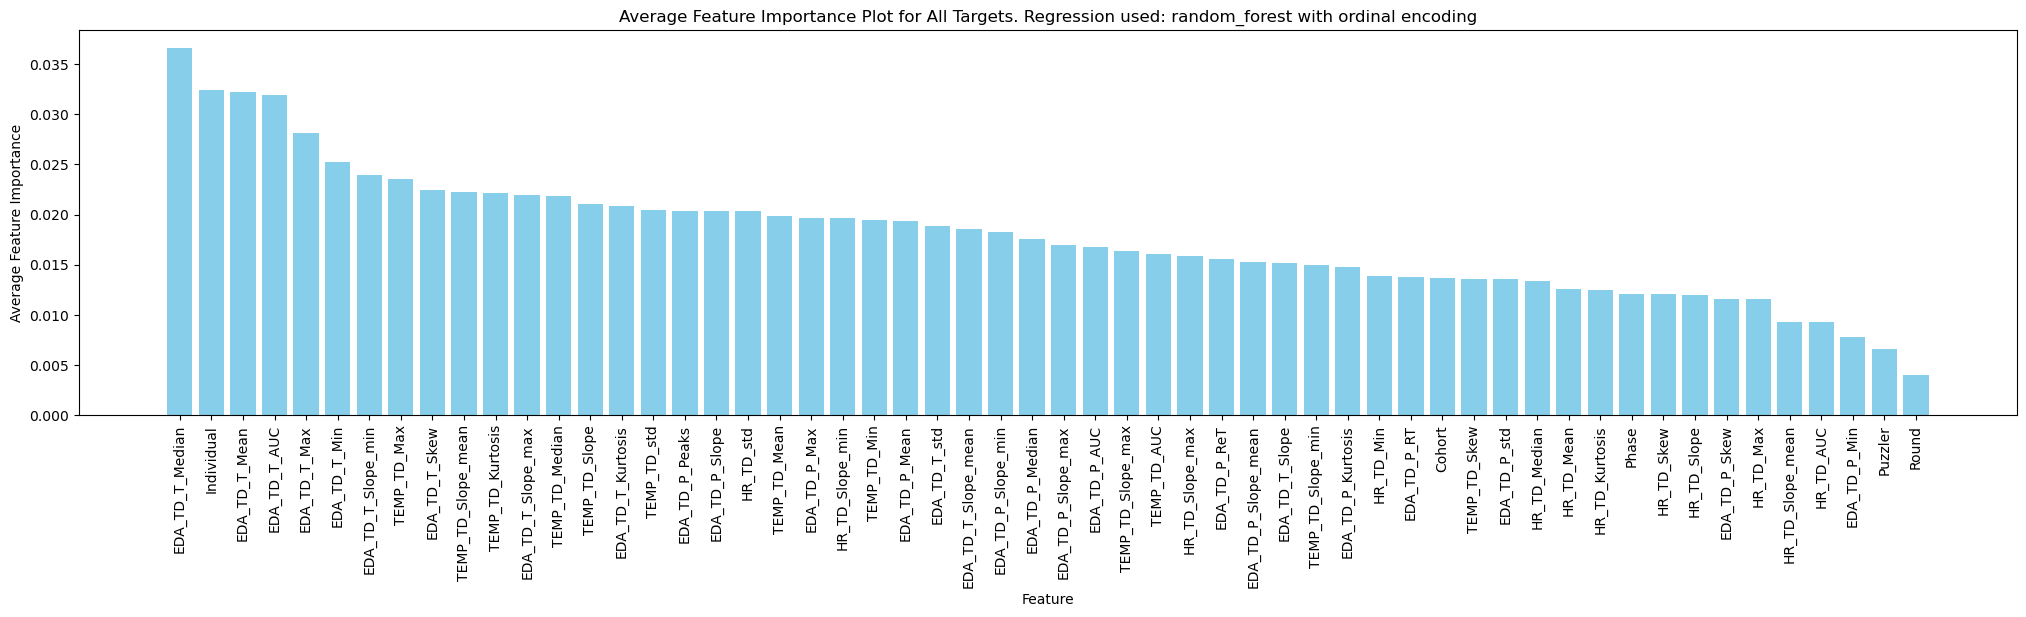

In [311]:
random_forest_dummy_res = plot_average_feature_importances_all_targets(X_data.copy(), y_data.copy(), random_forest_dummy, y_string, 'dummy', 'random_forest', show_plot = True)
random_forest_ordinal_res = plot_average_feature_importances_all_targets(X_data.copy(), y_data.copy(), random_forest_ordinal, y_string, 'ordinal', 'random_forest', show_plot = True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


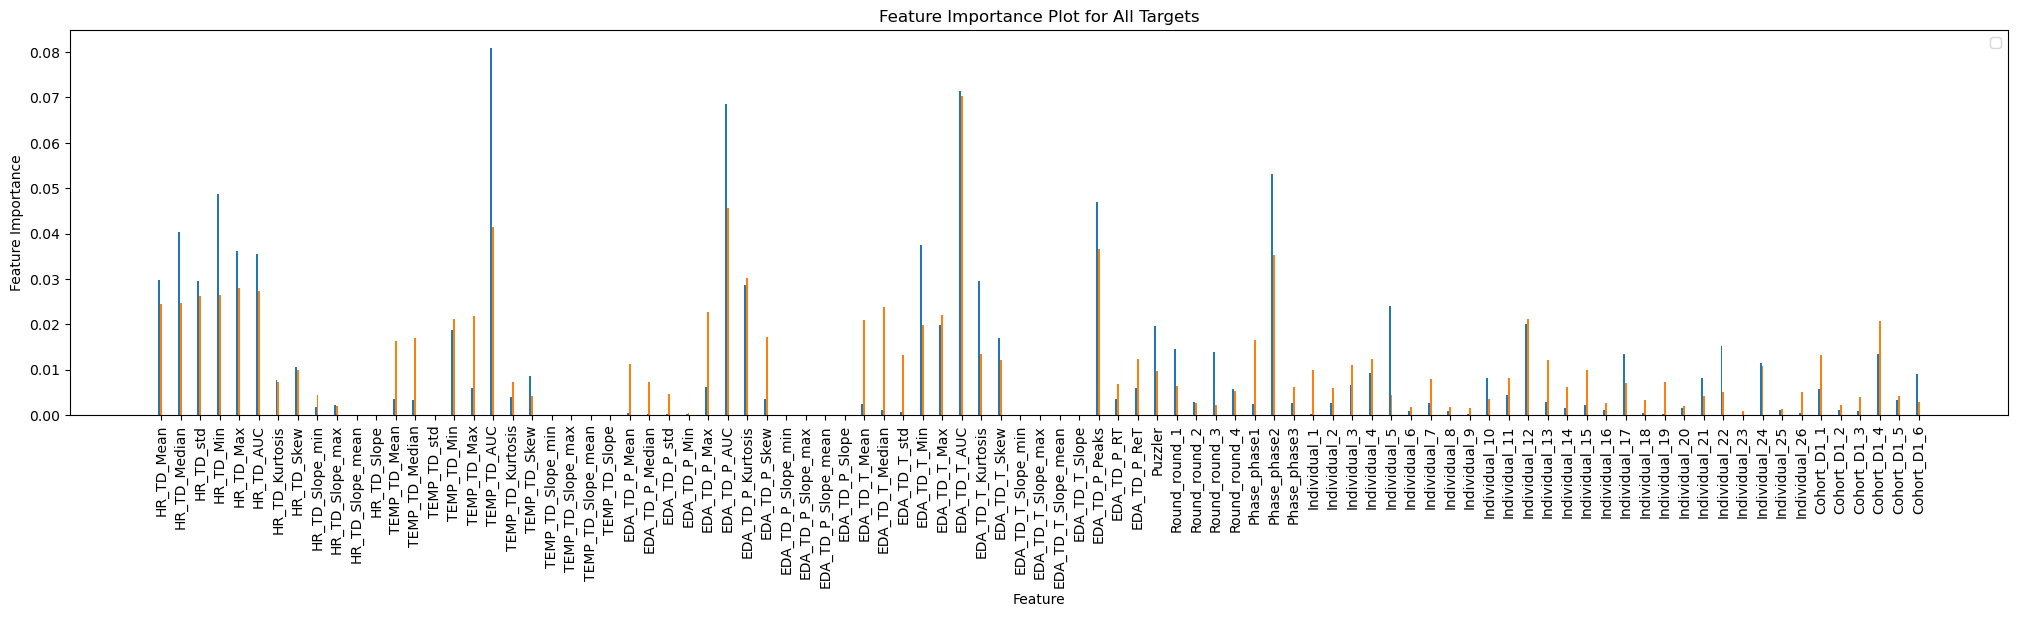

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


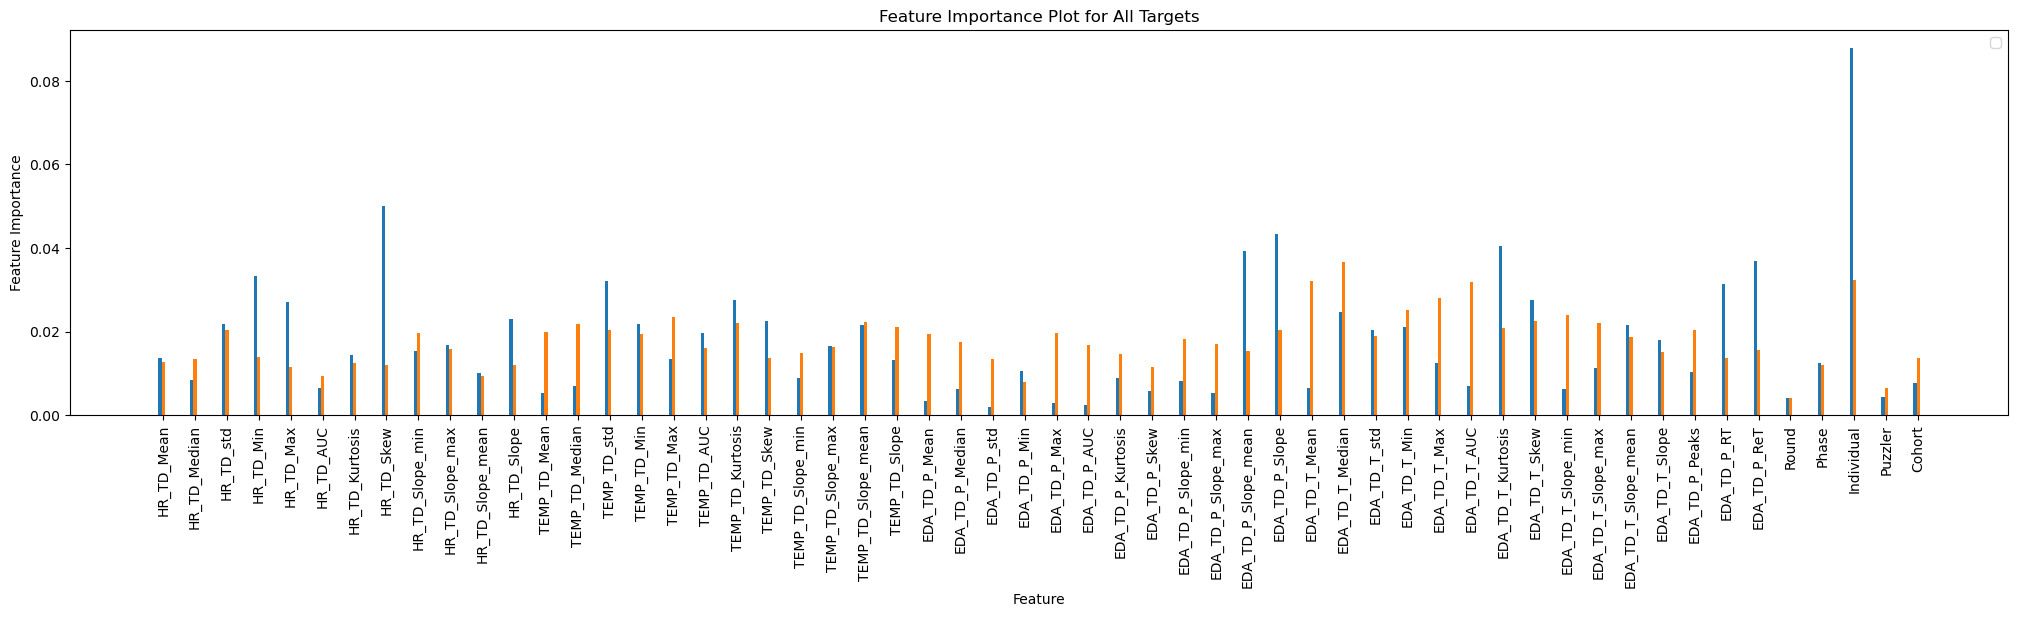

In [313]:
list_dummy = [adaboost_dummy_res, random_forest_dummy_res]
plot_average_feature_different_regression(list_dummy)

list_ordinal = [adaboost_ordinal_res, random_forest_ordinal_res]
plot_average_feature_different_regression(list_ordinal)